# 8-13. 프로젝트: 뉴스기사 요약해보기

### Step 1. 데이터 수집하기

- https://github.com/sunnysai12345/News_Summary
- 윗 링크에서 제공되는 뉴스 기사 텍스트 사용

In [1]:
# 필요한 패키지 불러오기
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# colab TPU 사용을 위한 코드
import tensorflow as tf
resolver=tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

print('=3')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.88.101.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.88.101.194:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


=3


In [2]:
# 데이터 가져오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
26287,You remind me of dad: Priyanka to her brother ...,Priyanka Chopra took to Instagram to wish her ...
40130,US vetoes UN resolution giving 'protection' to...,The US on Friday vetoed a Kuwait-drafted UN Se...
78225,Delhi man beaten to death for not paying back ...,A 20-year-old man was allegedly beaten to deat...
73032,Investor files class action suit against Dr. R...,Pharmaceutical company Dr. Reddy's Laboratorie...
68083,Muslim group manages Durga Puja committee in B...,The Kirodimal Gajanand Durga Puja Committee in...
49316,The nation is obsessed with Big B: Pad Man dir...,"Filmmaker R Balki, while talking about Amitabh..."
23379,Aussie media mocks Kohli over dismissals in En...,An Australian channel took a dig at India capt...
87553,Millionaire and hot yoga guru Bikram gets arre...,A US court has issued an arrest warrant for Bi...
26611,US woman on oxygen dies after power shut over ...,A 68-year-old US woman who was reliant on an o...
77827,Huma Qureshi turns showstopper for Rina Dhaka'...,Actress Huma Qureshi turned showstopper for de...


In [4]:
data.shape

(98401, 2)

In [5]:
# text 한 개 확인해보기
print(len(data['text'][0].split())) # 대략적 문장 길이 확인
data['text'][0]

60


"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [6]:
# headlines 한 개 확인해보기
print(len(data['headlines'][0].split()))
data['headlines'][0]

13


'upGrad learner switches to career in ML & Al with 90% salary hike'

### Step 2. 데이터 전처리하기 (추상적 요약)

- 실습시 사용한 전처리 외에 추가적으로 더 필요한지 생각해보기
- 만약 불용어를 제거한다면, headlines에도 불용어 제거가 좋을지도 고민해보기

#### # 중복값 제거

In [7]:
# 확인용으로 원래 데이터 갯수 저장
original_len = len(data)
original_len

98401

In [8]:
data.duplicated().sum()

22

In [9]:
print('headlines 유니크:', data['headlines'].nunique())
print('text 유니크:', data['text'].nunique())

headlines 유니크: 98280
text 유니크: 98360


> 컬럼별로 중복 여부가 다를 수 있으니 `data.duplicated().sum()`와 같이 하면 갯수 착오가 일어날 수 있다.

In [10]:
# headlines 중복은 실제 의미있는 데이터일 수도 있으니 text의 중복만 삭제
data = data.drop_duplicates(subset='text')
print(len(data))

98360


#### # Null 값 제거

In [11]:
# Null값 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

> 현 시점에서 문장들의 길이 분포를 확인해보려 한다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553660024400163


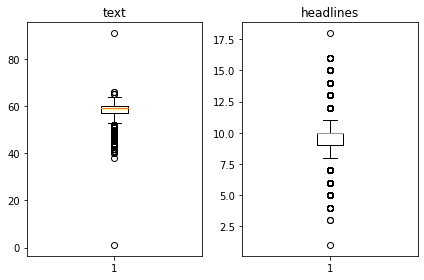

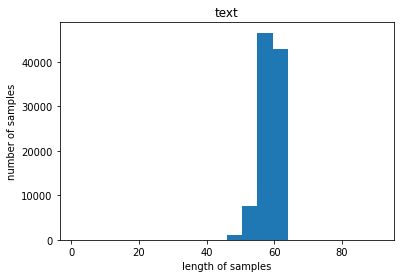

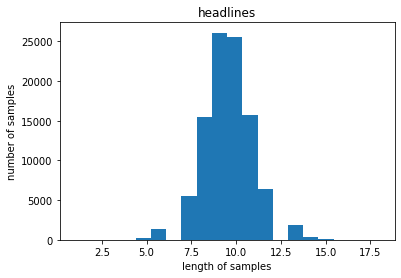

In [12]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 20)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 20)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### # 텍스트 정규화( normalisation)

In [13]:
# 정규화 사전 딕셔너리 형태로 할당
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


> 뒤에 가서 regex 처리와 함께 할 예정

#### # 불용어 제거

In [14]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

> - 'out', 'off'등 동사와 짝을 이루어 문맥상 의미를 잘 살려주는 단어는 불용어에서 빼보면 좋을 것 같다.  
> - 그리고 데이터에 있는 문장 자체가 비교적 짧은 것 같아 불용어를 많이 제외하면 의미 해석에 어려움이 생기는 문장도 생길 것 같아서 'why', 'most', 'only' 등 불용어 개수를 많이 줄여보기로 했다. 

In [15]:
# 코드는 stackoverflow를 참조하였다.

# 원래 불용어
original_stopwords = stopwords.words('english')

# 불용어에서 제외할 목록
not_stopwords = {'before', 'after', 'out', 'in', 'off', 'why', 'how', 'most', 'only', 'more', 'all', 'is', 'been', 'have', 'for', 'against', 'where', 'when'} 

# 새로운 불용어
new_stopwords = list(set([word for word in original_stopwords if word not in not_stopwords]))

print('새로운 불용어 개수 :', len(new_stopwords))
print(new_stopwords)

새로운 불용어 개수 : 161
['of', 'few', 'we', "weren't", 'what', "needn't", "mightn't", 'an', 'should', 'now', 'weren', 'isn', 'can', 'its', "wouldn't", 'from', 'myself', 'each', 'doing', 'once', "it's", 'll', 'own', 'up', "haven't", "mustn't", 'our', "you'd", 'her', 'yourself', 'mustn', 'there', "couldn't", 'wouldn', 'but', 'did', 'him', 'd', 'wasn', 'you', 'couldn', 'shouldn', "hasn't", 'this', 'over', 'ma', 'theirs', 'o', 'am', 'won', 'm', 'don', "isn't", 'himself', 'below', "hadn't", "don't", "you'll", 'needn', 'your', 'or', 'hadn', 'will', 'ours', "shouldn't", 'than', 'both', 'these', 'yourselves', 'any', 'being', 'a', 'other', 'no', 'his', 'between', 'because', 'hers', "should've", "you're", 'that', 'too', 'above', 'while', 'had', 'whom', 'herself', 'on', 'haven', 'does', "won't", 'having', 'nor', 'just', 'as', 've', 'itself', 'mightn', 'be', 'further', 'ain', 'doesn', 'to', 'into', 'about', 'through', 'with', 'not', 'by', 'under', 'then', 'who', 'down', 'hasn', 'themselves', 'those', 've

#### # 특수문자 처리 함수 정의

In [16]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in new_stopwords if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [17]:
# sample data로 확인해보기

print('Before :')
print(data['text'][0])
print('===================================================================================')
print('After :')
print(preprocess_sentence(data['text'][0]))

Before :
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
After :
saurav kant alumnus upgrad iiit pg program in machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers


> 전문적인 단어가 들어가면 의미를 더해주는 각종 조사와 대문자 같은 게 사라지니까 해석에 난감해지는 것 같다...

#### # 전처리 함수 실행

In [18]:
# 전체 텍스트에 실행
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:3])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program in machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy for one year pranav kaushik delhi techie bagged reward after spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit more', 'new zealand defeated india wickets in fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy after consecutive victories dating back march match witnessed india getting all out for seventh lowest total in odi cricket history']


In [19]:
# headlines에는 불용어 제거 미적용
clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, remove_stopwords=False))

print(clean_headlines[:3])

['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak']


In [20]:
# null 값으로 변한 거 있는지 확인

data.isnull().sum()

headlines    0
text         0
dtype: int64

In [21]:
# 전처리된 데이터 할당
data['text'] = clean_text
data['headlines'] = clean_headlines

#### # train, test 데이터 나누기

text min  : 1
text max  : 60
text mean : 38.78533956893046
text count : 98360
text 95% len : 45.0
headlines min  : 1
headlines max  : 16
headlines mean : 9.299532330215534
headlines count : 98360
headlines 95% len : 12.0


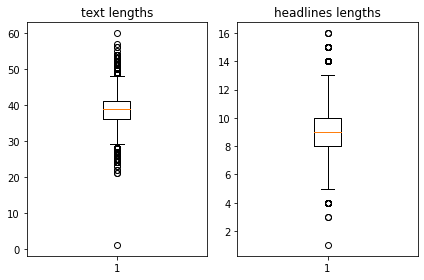

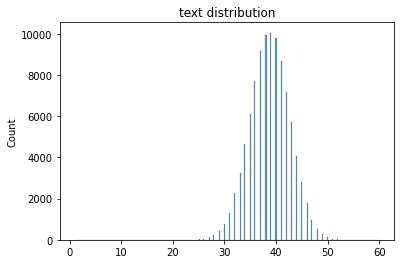

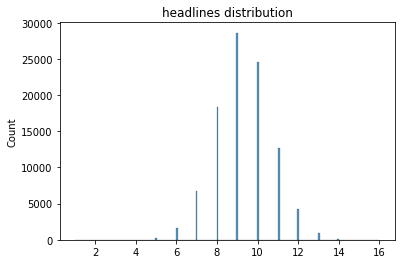

In [22]:
# 현 시점 길이 분포 출력

import seaborn as sns

text_each_len = [len(sentence.split()) for sentence in data['text']]
headlines_each_len = [len(sentence.split()) for sentence in data['headlines']]
text_qt = np.percentile(text_each_len, 95)
headlines_qt = np.percentile(headlines_each_len, 95)


print(f'text min  : {np.min(text_each_len)}')
print(f'text max  : {np.max(text_each_len)}')
print(f'text mean : {np.mean(text_each_len)}')
print(f'text count : {len(text_each_len)}')
print(f'text 95% len : {text_qt}')
print('==================================================================')
print(f'headlines min  : {np.min(headlines_each_len)}')
print(f'headlines max  : {np.max(headlines_each_len)}')
print(f'headlines mean : {np.mean(headlines_each_len)}')
print(f'headlines count : {len(headlines_each_len)}')
print(f'headlines 95% len : {headlines_qt}')
print('==================================================================')

      
plt.subplot(1, 2, 1)
plt.boxplot(text_each_len)
plt.title('text lengths')
plt.subplot(1, 2, 2)
plt.boxplot(headlines_each_len)
plt.title('headlines lengths')
plt.tight_layout()
plt.show()


sns.histplot(text_each_len)
plt.title('text distribution')
plt.show()

sns.histplot(headlines_each_len)
plt.title('headlines distribution')
plt.show()

In [23]:
# 위 데이터를 토대로 전체 데이터의 95%를 커버할 수 있는 max_len을 각각 적용
text_max_len = int(text_qt)
headlines_max_len = int(headlines_qt)

print(text_max_len, headlines_max_len)

45 12


In [24]:
# 컬럼마다 max_len에 맞춰서 넘는 건 제외시키기
# 1) text 컬럼부터 제외
text_mask = data['text'].apply(lambda sentence: len(sentence.split()) <= text_max_len)
print(f'Before text_mask : {len(data)}')
data = data[text_mask]
print(f'After text_mask : {len(data)}')

# 2) headlines 컬럼 제외
headlines_mask = data['headlines'].apply(lambda sentence: len(sentence.split()) <= headlines_max_len)
print(f'Before headlines_mask : {len(data)}')
data = data[headlines_mask]
print(f'After headlines_mask : {len(data)}')


Before text_mask : 98360
After text_mask : 94521
Before headlines_mask : 94521
After headlines_mask : 93397


> 이 부분에서 max_len을 각각 컬럼마다 정해주고 또 그에 맞지 않는 데이터는 잘라냈었는데, 이 이유에 대해 문득 의문이 들었었다. 근데 결국 나중에 모델에 넣어주기 위해 일괄적인 길이를 갖게 해야 하는데 해당 길이를 정의해주는 부분이라고 생각하면 될 것 같다.

#### # `sostoken`, `eostoken` 넣은 컬럼 만들기

In [25]:
data.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program in ...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets in fourth o...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...
6,india get all out for their lowest odi total i...,india recorded lowest odi total in new zealand...


In [26]:
# 각각 컬럼 만들기
data['sos_added'] = data['headlines'].apply(lambda sentence: 'sostoken ' + sentence)
data['end_added'] = data['headlines'].apply(lambda sentence: sentence + ' eostoken')

data.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,headlines,text,sos_added,end_added
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program in ...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets in fourth o...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...


In [27]:
# end_added 잘 안보여서 확인
data['end_added'][0]

'upgrad learner switches to career in ml al with salary hike eostoken'

In [28]:
# Numpy array로 만들기
encoder_input = np.array(data['text'])
decoder_input = np.array(data['sos_added'])
decoder_target = np.array(data['end_added'])

print(f'encoder_input len  : {len(encoder_input)}')
print(f'decoder_input len  : {len(decoder_input)}')
print(f'decoder_target len : {len(decoder_target)}')

encoder_input len  : 93397
decoder_input len  : 93397
decoder_target len : 93397


#### # 3개의 어레이를 각각 train, test용으로 나누기(총 6개로 만들기)

> train_test_split을 쓰려 했으나 나눠야 하는 어레이가 3개여서 LMS 실습처럼 manual하게 나누는 방법을 따른다.

In [29]:
# 섞을 indices 생성
array_for_shuffle = np.arange(len(encoder_input))
np.random.shuffle(array_for_shuffle)

shuffled_indices = array_for_shuffle
shuffled_indices

array([81061, 50030, 65852, ..., 47396,   696, 38475])

In [30]:
# shuffled_indices를 넣어서 섞어주기
encoder_input = encoder_input[shuffled_indices]
decoder_input = decoder_input[shuffled_indices]
decoder_target = decoder_target[shuffled_indices]

# 8:2 정도로 나눠주기
train_len = round(len(encoder_input) * 0.8)

# <--------------- 추후 추출적 요약(Extractive Summarization)을 위한 변수 한 개 생성
es_input = encoder_input[:train_len].copy()
# <------------------------------------------------------------------------

# 데이터 나누기
encoder_input_train = encoder_input[:train_len]
decoder_input_train = decoder_input[:train_len]
decoder_target_train = decoder_target[:train_len]

encoder_input_test = encoder_input[train_len:]
decoder_input_test = decoder_input[train_len:]
decoder_target_test = decoder_target[train_len:]

print(encoder_input_train.shape)
print(encoder_input_test.shape)

(74718,)
(18679,)


#### # encoder_input_train, decoder_input_train 각각 토큰화해서 빈도수를 토대로 각각 단어 갯수 줄여주기

In [31]:
# encoder_input_train 토큰화
en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(encoder_input_train)

# 토큰화 잘 됐는지 5개만 확인
i = 0 
for k, v in en_tokenizer.word_index.items():
    print((k, v))
    i += 1
    if i == 5:
        break

('in', 1)
('for', 2)
('said', 3)
('is', 4)
('after', 5)


In [32]:
# encoder_input_train의 단어 사전 내 빈도수 확인
# 여러번 확인을 통해 단어 개수 측면에서는 약 25%만 살리면서 전체 데이터의 빈도는 95% 정도만 살리는 threshold를 12로 결정
threshold = 12
total_cnt = len(en_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in en_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67612
등장 빈도가 11번 이하인 희귀 단어의 수: 51435
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16177
단어 집합에서 희귀 단어의 비율: 76.07377388629237
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.885376583504237


> encoder vocab은 약 16000개로 결정

In [33]:
enc_vocab = 16000
enc_tokenizer = Tokenizer(num_words=enc_vocab)
enc_tokenizer.fit_on_texts(encoder_input_train)

# 빈도수 상위 5개 확인
sorted([(v, k) for k, v in enc_tokenizer.word_counts.items()], reverse=True)[:5]

[(97640, 'in'),
 (41577, 'for'),
 (41062, 'said'),
 (34998, 'is'),
 (21309, 'after')]

In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = enc_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = enc_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[570, 85, 6389, 5844, 395, 77, 6318, 4577, 15542, 13401, 3514, 705, 8379, 223, 88, 1982, 8834, 4, 3404, 2, 33, 715, 4, 2226, 694, 8235, 9363, 1236, 35, 178, 223, 104, 2462, 149, 2080, 8379, 1828, 3514, 13401], [1002, 390, 1513, 2, 470, 38, 1810, 204, 1412, 995, 507, 1272, 164, 121, 484, 141, 102, 143, 39, 30, 6, 10, 1080, 1145, 3026, 204, 3, 954, 204, 1024, 2964, 1864, 1653, 1045, 910, 1162, 536, 1811, 1425], [219, 15, 259, 5, 5661, 8998, 2764, 1, 1279, 235, 99, 13, 95, 3, 881, 686, 4827, 745, 3576, 970, 3465, 1109, 1370, 1275, 2764, 4787, 2, 834, 539, 12, 50, 974, 14921, 12950]]


##### # decoder_input도 토큰화 진행

In [35]:
# decoder_input_train 토큰화
de_tokenizer = Tokenizer()
de_tokenizer.fit_on_texts(decoder_input_train)

# 'eostoken'추가를 위한 decoder_target_train 토큰화
de_tokenizer.fit_on_texts(decoder_target_train)

# 토큰화 잘 됐는지 5개만 확인
i = 0 
for k, v in de_tokenizer.word_index.items():
    print((k, v))
    i += 1
    if i == 5:
        break

('sostoken', 1)
('eostoken', 2)
('to', 3)
('in', 4)
('for', 5)


In [36]:
# decoder_input_train의 단어 사전 내 빈도수 확인
# 여러번 확인을 통해 단어 개수 측면에서는 약 25%만 살리면서 전체 데이터의 빈도는 95% 정도만 살리는 threshold를 7로 결정
threshold = 7
total_cnt = len(de_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in de_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29553
등장 빈도가 6번 이하인 희귀 단어의 수: 16751
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12802
단어 집합에서 희귀 단어의 비율: 56.681216796941094
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.300905447179636


> decoder vocab은 9000으로 결정

In [37]:
dec_vocab = 9000
dec_tokenizer = Tokenizer(num_words=dec_vocab)
dec_tokenizer.fit_on_texts(decoder_input_train)
dec_tokenizer.fit_on_texts(decoder_target_train) # 'eostoken' 추가

# 빈도수 상위 5개 확인
sorted([(v, k) for k, v in dec_tokenizer.word_counts.items()], reverse=True)[:5]

[(74718, 'sostoken'),
 (74718, 'eostoken'),
 (47088, 'to'),
 (39802, 'in'),
 (23278, 'for')]

In [38]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = dec_tokenizer.texts_to_sequences(decoder_input_train)
decoder_input_test = dec_tokenizer.texts_to_sequences(decoder_input_test)

# 잘 진행되었는지 샘플 출력
print(decoder_input_train[:3])
print('====================================================================')
print(decoder_input_test[:3])

[[1, 157, 149, 4242, 3, 3269, 6656, 5224, 5474, 486], [1, 283, 6, 97, 4543, 679, 556, 3, 680, 154], [1, 122, 11, 7031, 101, 2080, 4, 595]]
[[1, 129, 827, 266, 81, 403, 4712, 5], [1, 18, 1037, 7, 107, 788, 2114, 17, 737], [1, 4130, 5, 151, 11, 49, 1623, 31, 452, 5, 2428, 8367]]


##### # decoder_target도 decoder_input 토큰을 통해 정수화 진행

In [39]:
decoder_target_train = dec_tokenizer.texts_to_sequences(decoder_target_train)
decoder_target_test = dec_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 진행되었는지 샘플 출력
print(decoder_target_train[:3])
print('====================================================================')
print(decoder_target_test[:3])

[[157, 149, 4242, 3, 3269, 6656, 5224, 5474, 486, 2], [283, 6, 97, 4543, 679, 556, 3, 680, 154, 2], [122, 11, 7031, 101, 2080, 4, 595, 2]]
[[129, 827, 266, 81, 403, 4712, 5, 2], [18, 1037, 7, 107, 788, 2114, 17, 737, 2], [4130, 5, 151, 11, 49, 1623, 31, 452, 5, 2428, 8367, 2]]


#### # 토큰화 후 빈도수가 낮은 단어를 단어 사전 내에서 제외하고 정수 인코딩 했을 때 제외된 단어만 갖고 있는 데이터가 있는지 확인

In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 74718
훈련 레이블의 개수 : 74718
테스트 데이터의 개수 : 18679
테스트 레이블의 개수 : 18679


#### # 패딩

In [41]:
# 'post'패딩으로 하는 이유가 있는 것 같다.
# 내가 파악한 게 맞다면, 맨 밑 쪽 회고에서 풀어낼 예정이다.
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [42]:
# 패딩 확인
encoder_input_train[1]

array([1002,  390, 1513,    2,  470,   38, 1810,  204, 1412,  995,  507,
       1272,  164,  121,  484,  141,  102,  143,   39,   30,    6,   10,
       1080, 1145, 3026,  204,    3,  954,  204, 1024, 2964, 1864, 1653,
       1045,  910, 1162,  536, 1811, 1425,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [43]:
# 패딩 확인
decoder_target_train[0]

array([ 157,  149, 4242,    3, 3269, 6656, 5224, 5474,  486,    2,    0,
          0], dtype=int32)

In [44]:
print(encoder_input_train.shape)
print(encoder_input_test.shape)

(74718, 45)
(18679, 45)


In [45]:
print(decoder_input_train.shape)
print(decoder_input_test.shape)

(74718, 12)
(18679, 12)


### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

#### Encoder 설계

In [46]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with strategy.scope():
    #============================================ 인코더 설계
    embedding_dim = 128
    hidden_size = 256

    # 인코더 Input
    encoder_inputs = Input(shape=(text_max_len,))

    # 인코더의 임베딩 층
    enc_emb = Embedding(enc_vocab, embedding_dim)(encoder_inputs)

    # 인코더의 LSTM 1
    encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

    # 인코더의 LSTM 2
    encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

    # 인코더의 LSTM 3
    encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

    #============================================ 디코더 설계
    decoder_inputs = Input(shape=(None,))

    # 디코더의 임베딩 층
    dec_emb_layer = Embedding(dec_vocab, embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs)

    # 디코더의 LSTM
    decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    # 어텐션 층(어텐션 함수)
    from tensorflow.keras.layers import AdditiveAttention
    attn_layer = AdditiveAttention(name='attention_layer')

    # 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
    attn_out = attn_layer([decoder_outputs, encoder_outputs])

    # 어텐션의 결과와 디코더의 hidden state들을 연결
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    # 디코더의 출력층
    decoder_softmax_layer = Dense(dec_vocab, activation='softmax')
    decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

    #============================================ 모델 정의
    model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 128)      2048000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 45, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

#### # 컴파일 및 훈련

> 훈련이 너무 길어지고 EarlyStopping이 적용되지 않아서 에포크를 15로 낮췄다.

In [47]:
with strategy.scope():
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
    es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
    history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
              validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
              batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


292/292 [==============================] - 59s 122ms/step - loss: 5.5653 - val_loss: 5.1629
Epoch 2/50
292/292 [==============================] - 18s 62ms/step - loss: 5.0216 - val_loss: 4.7800
Epoch 3/50
292/292 [==============================] - 18s 62ms/step - loss: 4.6611 - val_loss: 4.4899
Epoch 4/50
292/292 [==============================] - 19s 64ms/step - loss: 4.3846 - val_loss: 4.3027
Epoch 5/50
292/292 [==============================] - 18s 63ms/step - loss: 4.1842 - val_loss: 4.1784
Epoch 6/50
292/292 [==============================] - 18s 62ms/step - loss: 4.0232 - val_loss: 4.0655
Epoch 7/50
292/292 [==============================] - 18s 62ms/step - loss: 3.8828 - val_loss: 3.9816
Epoch 8/50
292/292 [==============================] - 18s 62ms/step - loss: 3.7599 - val_loss: 3.9064
Epoch 9/50
292/292 [==============================] - 18s 63ms/step - loss: 3.6475 - val_loss: 3.8404
Epoch 10/50
292/292 [==============================] - 18s 63ms/step - loss: 3.5499 - val_lo

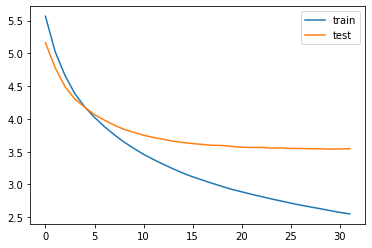

In [48]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

> - 그런데 왜 accuracy를 metrics로 넣지 않는 것일까?  
> - 혹시 text summarisation의 경우 accuracy로 훈련을 판단할 수 없는 걸까?  

> - 확인해 보니 text summarization도 accuracy 측정이 가능한 것 같다.  
> - (https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460) 링크에서 보면 ROGUE라는 지표 세트로 text summarization은 accuracy 측정이 가능하단다.

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

#### # 단어 집합에서 정수 <-> 단어 변환 준비

> 실제 output을 정수 <-> 단어로 바꿔서 표현할 수 있게 준비한다.

In [49]:
enc_index_to_word = enc_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
dec_word_to_index = dec_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
dec_index_to_word = dec_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [50]:
# type 확인 및 예시로 5개만 확인하기
print(type(enc_index_to_word))

i = 0
for k, v in enc_index_to_word.items():
    print(f'{k}:{v}')
    i += 1
    if i == 5:
        break

<class 'dict'>
1:in
2:for
3:said
4:is
5:after


In [51]:
# type 확인 및 예시로 5개만 확인하기
print(type(dec_word_to_index))

i = 0
for k, v in dec_word_to_index.items():
    print(f'{k}:{v}')
    i += 1
    if i == 5:
        break

<class 'dict'>
sostoken:1
eostoken:2
to:3
in:4
for:5


#### # inference 모델 설계

In [52]:
with strategy.scope():
    # 인코더 설계
    encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

    # 이전 시점의 상태들을 저장하는 텐서
    decoder_state_input_h = Input(shape=(hidden_size,))
    decoder_state_input_c = Input(shape=(hidden_size,))

    dec_emb2 = dec_emb_layer(decoder_inputs)

    # 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
    # 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
    decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

    # 어텐션 함수
    decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
    attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

    # 디코더의 출력층
    decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

    # 최종 디코더 모델
    decoder_model = Model(
        [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
        [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


#### # 단어 생성 함수 정의

In [53]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = dec_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = dec_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [54]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + enc_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=dec_word_to_index['sostoken']) and i!=dec_word_to_index['eostoken']):
            temp = temp + dec_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [55]:
# 20개 확인
for i in range(50, 70):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : mumbai indians dismissed for joint lowest ipl total sunrisers hyderabad registered run victory in ipl tuesday srh successfully defended runs is second lowest total ever defended in ipl only third match in year history tournament in all wickets fell 
실제 요약 : mi register their joint lowest ipl total in loss against srh 
예측 요약 :  mi beat mi by runs to register highest ipl loss


원문 : government wednesday introduced bill in lok sabha allow voluntary use aadhaar for services like opening bank accounts obtaining new sim cards bill also gives minors option opt out aadhaar scheme upon turning years provides for penalties crore for violating provisions aadhaar act 
실제 요약 : govt bill to allow voluntary use of aadhaar for 
예측 요약 :  aadhaar mandatory for aadhaar mandatory for aadhaar


원문 : audi tuesday unveiled first ever completely electric suv starting price in united states car go kmph in seconds top speed kmph audi is looking bring first all electric car india in fourth quarter 
실제 요약 : 

#### feedback
> - 'aadhaar mandatory for aadhaar mandatory for aadhaar'... 한 단어의 반복이 많다.
> - 'man finds pet car in front of him in mumbai`... 말도 안되는 문맥으로 원문에 없던 요약을 만들어냈는데, 기가 막히게 말이 되는 추출이다..

> - 솔직히 20개를 직접 확인해보니 단어는 비슷하게 뽑는 것 같은데, 잘 맞는 요약인지 모르겠다.
> - 그리고 원문과 상관 없는데 정말 말이 되는 요약을 만들어 낸 게 몇 개 눈에 띈다.

### Step 5. Summa을 이용해서 추출적 요약해보기

In [56]:
!pip install summa
from summa.summarizer import summarize

     |████████████████████████████████| 54 kB 2.0 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=9b90f77cf3db84a4135dabf69f23ce87e7569f5db0523bd518f1647c9fea94d2
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [57]:
# 5개만 실험으로 진행
for i in range(50, 55):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", summarize(seq2text(encoder_input_test[i])))
    print('\n')

원문 : mumbai indians dismissed for joint lowest ipl total sunrisers hyderabad registered run victory in ipl tuesday srh successfully defended runs is second lowest total ever defended in ipl only third match in year history tournament in all wickets fell 
실제 요약 : mi register their joint lowest ipl total in loss against srh 
예측 요약 : 


원문 : government wednesday introduced bill in lok sabha allow voluntary use aadhaar for services like opening bank accounts obtaining new sim cards bill also gives minors option opt out aadhaar scheme upon turning years provides for penalties crore for violating provisions aadhaar act 
실제 요약 : govt bill to allow voluntary use of aadhaar for 
예측 요약 : 


원문 : audi tuesday unveiled first ever completely electric suv starting price in united states car go kmph in seconds top speed kmph audi is looking bring first all electric car india in fourth quarter 
실제 요약 : audi unveils its st all electric suv set to launch in india 
예측 요약 : 


원문 : paris banned all sexist

> 훈련 때 쓴 encoder_input 텍스트는 무슨 이유에서인지 추출적 요약이 나오질 않아서 다른 식으로 되는지 해보자

In [58]:
# 5개만 실험으로 진행
for i in range(50, 55):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", summarize(es_input[i], ratio=0.5))
    print('\n')

원문 : mumbai indians dismissed for joint lowest ipl total sunrisers hyderabad registered run victory in ipl tuesday srh successfully defended runs is second lowest total ever defended in ipl only third match in year history tournament in all wickets fell 
실제 요약 : mi register their joint lowest ipl total in loss against srh 
예측 요약 : 


원문 : government wednesday introduced bill in lok sabha allow voluntary use aadhaar for services like opening bank accounts obtaining new sim cards bill also gives minors option opt out aadhaar scheme upon turning years provides for penalties crore for violating provisions aadhaar act 
실제 요약 : govt bill to allow voluntary use of aadhaar for 
예측 요약 : 


원문 : audi tuesday unveiled first ever completely electric suv starting price in united states car go kmph in seconds top speed kmph audi is looking bring first all electric car india in fourth quarter 
실제 요약 : audi unveils its st all electric suv set to launch in india 
예측 요약 : 


원문 : paris banned all sexist

> #### feedback
> - 어떤 식으로 해도 `summa.summarize()`로서 추출적 요약이 진행되지 않아서 이만 마무리한다.

## 회고

#### Point 1) 불용어 포함한 데이터의 효과
- 영어 뉴스 텍스트는 특성상 전문적인 용어, 즉 대문자로 시작하는 고유명사나 명칭 등이 많은데, 대문자 -> 소문자, 그리고 `'`삭제 등으로 인해 의미 해석이 난감해지는 것 같았다.
- 그리고 실제 텍스트는 어찌 됐든 모든 불용어를 포함해서 의미를 만들어내지 않던가...
- 불용어를 제외하지 않은 버전으로 모델에 넣어보는 것도 궁금하다.

#### Point 2) 한 눈에 보이지 않는 NLP 데이터
- NLP의 경우 텍스트 전처리가 많은 것 같은데, 이 때마다 잘 처리됐는지 확인하는 습관이 좋은 듯하다.
- 특히, NLP의 경우 이런 저런 특이한 케이스가 많은데 워낙 데이터 수가 많다 보니 일일이 확인하기 힘든 것 같다.
- 그래서 NLP 데이터 전처리 후에는 항상 `print()`해보고, 이를 통해 때때로 생기는 empty cell이나 코드 작성 잘못으로 엉뚱한 곳에 처리된 전처리를 방지하는 습관을 길러야겠다.

#### Point 3) optimizer 사용
- 실습 때 rmsprop을 사용해서 val_loss 가 줄어들지 않는 걸 보고 `adam`으로 해봤다.
- 돌려놓고 보고 loss들이 소수점 0.0001대까지 계속 떨어지며 epochs 50을 끝까지 채우고 있었다...
- EarlyStopping 콜백을 쓰면 무조건 빨리 끝나겠다 싶었는데, 그게 아니었다.
- 이를 통해 EarlyStopping이 발휘되는 조건을 알게 되었다.

#### Point 4) 모델의 이해
- 사실 아직도 RNN, LSTM, Attention 메커니즘이 잘 이해되지 않는다.
- 모델에 대한 공부가 필요함을 느끼고, 더불어 전체적인 공부량이 늘어나는 만큼 나의 진로 방향성을 뾰족하게 해서 더 집중하는 게 필요하겠다는 생각도 든다.

#### Point 5) val_loss가 loss보다 더 낮게 시작하는 이유
- 몇 번을 모델을 돌려봐도 항상 val_loss가 더 낮다.
- 이유가 뭘까...?
- 데이터 숫자가 가장 눈에 띄는 점인데, 데이터 수가 적으면 초기에는 무조건 어떤 가중치여도 더 잘 fit하다고 보면 되는 걸까?
- 이렇게 난해한 해석이 필요하거나 더 많은 실험이 필요한 경우에는 교육생, 퍼실 등등 많은 사람의 피드백과 의견 나눔이 있으면 공부에 더 좋을 것 같다.

#### Point 6) `요약 : sostoken sostoken sostoken...`의 이유
- 이 부분에서 굉장히 헤매면서 이번 프로젝트에서 굉장히 많은 점을 발견했다.
- 일단 내가 제일 먼저 겪었던 문제는 요약 문장 출력 시 나오는 알 수 없는 패턴이었다.
  - `sostoken man man man man man...`
  - 혹은 `sostoken appel appel appel appel...`
  - 이런 패턴이 한 번 나오면 모든 문장의 요약에서 계속 나왔는데, 아무리 찾아도 모델 설계, decode 함수에는 문제가 없었다.
  - 그래서 나는 처음 코드부터 차근차근 보기로 했다.(실습 시 코드와 비교하면서 봤다.)
  - 그래서 찾아낸 이유는 바로 `padding='pre'`와 `padding='post'`의 차이...
  - 실습시는 `'post'`였고, 나는 어디서 주워들은 걸 토대로 여기서는 `'pre'`로 데이터를 전처리했었다.
  - 그런데 생각해보니 이로 인해 input 문장들의 제일 처음 단어는 sostoken이 아니라 패딩이 되어버렸었다...
  - 그리고 이 때문에 sostoken이 요약 시 튀어나왔고, 그 이후에 한 단어가 나온 이유는... 아직 잘 모르겠다.
- 그리고 해결된 줄 알았던 나의 요약 출력은 `sostoken sostoken sostoken...` 출력으로 인해 다시 한 번 난관에 부딪혔다.
  - 근데 이 이유는 사실 단순했다.
  - 내가 모르고 어느 순간 손코딩을 하면서 decoder_target 변수에 실제 들어갈 `eostoken`으로 끝나는 문장이 아니라 `sostoken`으로 시작하는 문장을 넣어버린 것이다.
  - 이렇다 보니 훈련 시 `sostoken ....`으로 하는 것을 정답으로 훈련됐고,
  - 당연히 이로 인해 decode 함수의 코드에 따라 내 요약 문장은 `sostoken`의 무한 출력으로 변해버린 것이다.(`sostoken`이 확률이 제일 높게 나오니까...)
  - 여튼 이런 실수들을 통해 코드가 어떤 일을 하는지 깊숙하게 이해할 수 있었던 것 같다.

#### Point 7) summa 패키지 사용
- 음... 추출적 요약으로서 summa는 요약 문장을 반환할 때가 있고 안 할 때가 있다.
- 일단 나의 추측은,
- 1) 전부 다 소문자일 경우
- 2) 혹은 길이가 짧을 경우
- 이럴 때는 나오지 않았던 것 같다.
- 그리고 `words`라는 파라미터가 있는데 그게 진짜 영단어 기준으로 몇 개를 반환하는지 모르겠다.(왜냐하면 str은 알파벳 1개를 len() 1개로 나타내니까)
- 여튼 그런데 summa 패키지와 관련해서 제일 놀랍고 당혹스러웠던 것은 이 패키지에 대해 제대로된 documentation이 없다는 것이다...
- 사실 이렇게 `각 파라미터마다 의미하는 게 뭔지`, `어떤 걸 기준으로 텍스트가 반환되고 안 되는지`를 알기 힘든 이런 패키지는 실습 및 과제 때 사용되지 않는 게 좋을 것 같다.(이외에 다른 extractive summarization 패키지를 쓰려 했으나 여러 어려움이 있어서 시도를 중단했다.)